In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import torch
import library.functions.misc_helper_functions as misc_helpers
from library.functions import model_parameters
import library.data.data_helper_functions as data_helpers

import os, time

In [2]:
model_folder = "/work1/s174505/Thesis/Models/"
cnn_model_id = "13936780_0"

model_files = [f for f in os.listdir(model_folder) if cnn_model_id in f and "best" in f]
model_info = pd.Series({s : int(s.split("-")[3]) for s in model_files}, name="cv_index").sort_values()

model_dicts = {cv_index : torch.load(os.path.join(model_folder, model_file), map_location=torch.device("cpu")) for model_file, cv_index in model_info.items()}
for cv_index in model_dicts:
    model_dicts[cv_index]["optimizer_state_dict"] = None

In [3]:
[model_dicts[cv_index]["epoch"] for cv_index in model_dicts]
args = model_dicts[0]["args"]

In [4]:
if not os.path.exists("/work1/s174505/Thesis/Errors/Model_errors_"+cnn_model_id+".pty"):
    networks = {cv_index : None for cv_index in model_info}
    training_errors = {cv_index : None for cv_index in model_info}
    validation_errors = {cv_index : None for cv_index in model_info}
    test_errors = {cv_index : None for cv_index in model_info}
    training_true_values = {cv_index : None for cv_index in model_info}
    validation_true_values = {cv_index : None for cv_index in model_info}
    test_true_values = {cv_index : None for cv_index in model_info}
    for cv_index in model_info:
        args = model_dicts[cv_index]["args"]
        torch.random.manual_seed(args.seed)
        hyperparameters, model = model_parameters.parameters(args)
        net = model(hyperparameters).to(device=args.device, dtype=args.data_type)
        net.load_state_dict(model_dicts[cv_index]["model_state_dict"])
        net.eval()
        
        cv_folds = 21
        cv_folds_per_area = cv_folds//3
        cv_area_index = cv_index%cv_folds_per_area

        with torch.no_grad():
            X, y = torch.load(os.path.join(args.data_folder, args.training_data_file), map_location=torch.device("cpu"))

            val_area = cv_index//cv_folds_per_area
            X_splitted = X.to(dtype=args.data_type, device=args.device)
            y_splitted = y.to(dtype=args.data_type, device=args.device)
            val_x_area = X_splitted[val_area].split(X.shape[-1]//cv_folds_per_area,dim=-1)
            val_y_area = y_splitted[val_area].split(y.shape[-1]//cv_folds_per_area,dim=-1)

            X_before_validation = [val_x_area[i] for i in range(cv_area_index)]
            X_after_validation = [val_x_area[i] for i in range(cv_area_index+1,len(val_x_area))]
            y_before_validation = [val_y_area[i] for i in range(cv_area_index)]
            y_after_validation = [val_y_area[i] for i in range(cv_area_index+1,len(val_y_area))]

            train_samples = [(X_splitted[i],y_splitted[i]) for i in range(3) if i != val_area]
            val_sample = [(val_x_area[cv_area_index], val_y_area[cv_area_index])]
            if len(X_before_validation) > 0:
                train_samples.append( (torch.hstack(X_before_validation), torch.hstack(y_before_validation)) )
            if len(X_after_validation) > 0:
                train_samples.append( (torch.hstack(X_after_validation), torch.hstack(y_after_validation)) )

            train_samples = data_helpers.crop_data_v2(train_samples, net, args)
            val_sample    = data_helpers.crop_data_v2(val_sample,    net, args)

            training_errors[cv_index] = [(net(x[None,:,:].to(device=args.device)) - y.to(device=args.device)).to(device=torch.device("cpu")) for x,y in train_samples]
            validation_errors[cv_index] = [(net(x[None,:,:].to(device=args.device)) - y.to(device=args.device)).to(device=torch.device("cpu")) for x,y in val_sample]
            training_true_values[cv_index] = [y.to(device=torch.device("cpu")) for _,y in train_samples]
            validation_true_values[cv_index] = [y.to(device=torch.device("cpu")) for _,y in val_sample]
            
            X_test, y_test = torch.load(os.path.join(args.data_folder, args.testing_data_file), map_location=args.device)
            X_test = X_test.to(dtype=args.data_type, device=args.device)
            y_test = y_test.to(dtype=args.data_type, device=args.device)
            y_test = data_helpers.crop_data(X_test, y_test, net, args)

            test_errors[cv_index] = (net(X_test) - y_test).to(device=torch.device("cpu"))
            test_true_values[cv_index] = y_test.to(device=torch.device("cpu"))

    torch.cuda.empty_cache()
else:
    positions, training_errors, validation_errors, test_errors, training_true_values, validation_true_values, test_true_values = \
        torch.load("/work1/s174505/Thesis/Errors/Model_errors_"+cnn_model_id+".pty")

In [5]:
35.30/(10.121185064315796*6)*3600

2092.640324765348

In [6]:
dynamics,irregularities,pos_dynamics = torch.load(os.path.join(args.data_folder, "Real_data.pt"), map_location=torch.device("cpu"))
print(dynamics.shape)
print(irregularities.shape)
print(pos_dynamics.shape)
df_dynamics = pd.DataFrame(dynamics, index=pos_dynamics.numpy())
df_irregularities = pd.DataFrame(irregularities, index=pos_dynamics.numpy())

torch.Size([281827, 38])
torch.Size([281827, 12])
torch.Size([281827])


In [7]:
position = torch.arange(281821)/2
positions = {cv_index : {"train" : None, "val" : None, 
    "test" : [position[0:23941], position[93941:117881], position[187881:211821]]} for cv_index in model_info}

pos_train_raw = [position[23941:93941], position[117881:187881], position[211821:281821], ]

cv_folds = 21
cv_folds_per_area = cv_folds//3
for cv_index in model_info:
    cv_area_index = cv_index%cv_folds_per_area
    val_idx = cv_index//cv_folds_per_area
    pos_areas_splitted = pos_train_raw[val_idx].split(pos_train_raw[0].shape[-1]//cv_folds_per_area,dim=-1)
    val_area = pos_areas_splitted[cv_area_index]
    reduction = len(val_area) - validation_errors[cv_index][0].shape[-1]
    positions[cv_index]["val"] = val_area[int(reduction/2):-int(reduction/2)]
    
    pos_before_validation = [pos_areas_splitted[i] for i in range(cv_area_index)]
    pos_after_validation = [pos_areas_splitted[i] for i in range(cv_area_index+1,len(pos_areas_splitted))]

    train_positions = [pos_train_raw[i] for i in range(3) if i != val_idx]
    if len(pos_before_validation) > 0:
        train_positions.append( torch.hstack(pos_before_validation) )
    if len(pos_after_validation) > 0:
        train_positions.append( torch.hstack(pos_after_validation) )
    
    for i in range(len(training_errors[cv_index])):
        reduction = len(train_positions[i]) - training_errors[cv_index][i].shape[-1]
        train_positions[i] = train_positions[i][int(reduction/2):-int(reduction/2)]
        positions[cv_index]["train"] = train_positions

    for i in range(3):
        positions[cv_index]["test"][i] = positions[cv_index]["test"][i][int(reduction/2):-int(reduction/2)]
    

In [8]:
if not os.path.exists("/work1/s174505/Thesis/Errors/Model_errors_"+cnn_model_id+".pty"):
    torch.save((positions, training_errors, validation_errors, test_errors, training_true_values, validation_true_values, test_true_values), 
        "/work1/s174505/Thesis/Errors/Model_errors_"+cnn_model_id+".pty")

In [9]:
val_errors = torch.concat([validation_errors[cv_index][0] for cv_index in model_info])
val_errors_collected = torch.concat([validation_errors[cv_index][0] for cv_index in model_info], dim=-1).squeeze()
train_errors_collected = torch.concat([training_errors[cv_index][0] for cv_index in model_info], dim=-1).squeeze()
val_true_values = torch.stack([validation_true_values[cv_index][0] for cv_index in model_info])
train_true_values = torch.stack([training_true_values[cv_index][0] for cv_index in model_info])
val_true_values_collected = torch.concat([validation_true_values[cv_index][0] for cv_index in model_info], dim=-1).squeeze()
train_true_values_collected = torch.concat([training_true_values[cv_index][0] for cv_index in model_info], dim=-1).squeeze()
print(val_errors.shape, val_errors_collected.shape, train_errors_collected.shape)

print(train_errors_collected.abs().mean(1))

test_errors_collected = torch.concat(tuple(test_errors.values()), dim=-1)
test_errors = torch.stack(tuple(test_errors.values()))
test_true_values_collected = torch.concat(tuple(test_true_values.values()), dim=-1)
test_true_values = torch.stack(tuple(test_true_values.values()))

torch.Size([6, 12, 9192]) torch.Size([12, 55152]) torch.Size([12, 415152])
tensor([0.1485, 0.1374, 0.2627, 0.2487, 0.1424, 0.1346, 0.1946, 0.1845, 0.1648,
        0.1589, 0.2104, 0.2046])


In [10]:
labels_X = [
    'Velocity', 'AccB1Y', 'AccB1Z', 'AccCR1Y', 'AccCR1Z', 'AccB2Y', 'AccB2Z', 
    'AccCR2Y', 'AccCR2Z', 'AccB3Y', 'AccB3Z', 'AccCR3Y', 'AccCR3Z', 'AccB4Y', 
    'AccB4Z', 'AccCR4Y', 'AccCR4Z', 'AccB5Y', 'AccB5Z', 'AccCR5Y', 'AccCR5Z', 
    'AccB6Y', 'AccB6Z', 'AccCR6Y', 'AccCR6Z', 'AccB7Y', 'AccB7Z', 'AccCR7Y', 
    'AccCR7Z', 'AccB8Y', 'AccB8Z', 'AccCR8Y', 'AccCR8Z', 
    'AccCSAY', 'AccCSAZ', 'AccCSBY', 'AccCSBZ', 
    'Curvature' 
]
labels_y = [
    'Lateral left D1', 'Lateral right D1', 'Vertical left D1', 'Vertical right D1', 
    'Lateral left D2', 'Lateral right D2', 'Vertical left D2', 'Vertical right D2', 
    'Lateral left D3', 'Lateral right D3', 'Vertical left D3', 'Vertical right D3', 
]

In [11]:
val_errors_collected.shape

torch.Size([12, 55152])

In [12]:
df_raw_val = pd.DataFrame({
    "Validation errors" : val_errors.reshape(-1),
    "Validation true values" : val_true_values.reshape(-1)})
df_raw_val2 = pd.DataFrame({
    "Validation errors" : val_errors[[0,1,2,3,5]].reshape(-1),
    "Validation true values" : val_true_values[[0,1,2,3,5]].reshape(-1)})
df_raw_train = pd.DataFrame({
    "Training errors" : train_errors_collected.reshape(-1),
    "Training true values" : train_true_values_collected.reshape(-1),
    })

In [13]:
print(train_errors_collected.abs().mean(), val_errors_collected.abs().mean())
print(train_errors_collected.abs().quantile(0.95), val_errors_collected.abs().quantile(0.95))
print(train_errors_collected.abs().max(), val_errors_collected.abs().max())

tensor(0.1827) tensor(0.3247)
tensor(0.5173) tensor(0.9801)
tensor(5.1874) tensor(14.4173)


/tmp/ipykernel_3011/3835079904.py:36: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)
/tmp/ipykernel_3011/3835079904.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


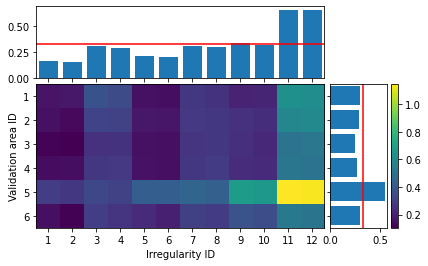

In [14]:
# definitions for the axes
left, width = 0.05, 0.80
bottom, height = 0.07, 0.40
spacing = 0.015

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)#, sharex=ax)
ax_histy = fig.add_axes(rect_histy)#, sharey=ax)

im = ax.imshow(val_errors.abs().mean(-1).numpy())

ax_histx.bar(np.arange(12), val_errors.abs().mean([0, 2]).numpy())
ax_histx.axhline(0.33, color="r")
ax_histx.set_xlim([-.5, 11.5])
ax_histy.barh(np.arange(6), val_errors.abs().mean([1, 2]).numpy()[::-1])
ax_histy.axvline(0.33, color="r")
ax_histy.set_ylim([-.5, 5.5])

ax_histx.set_xticks([i for i in range(12)])
ax_histy.set_yticks([i for i in range(6)])
ax_histx.set_xticklabels([])
ax_histy.set_yticklabels([])

ax.set_xticks([i for i in range(0,12)])
ax.set_xticklabels([i for i in range(1,13)])
ax.set_yticks([i for i in range(0,6)])
ax.set_yticklabels([i for i in range(1,7)])

plt.colorbar(im)
ax.set_xlabel("Irregularity ID")
ax.set_ylabel("Validation area ID")

fig.tight_layout()

fig.savefig("plots/Errors mean aggregates.pdf", format="pdf",bbox_inches="tight")

/tmp/ipykernel_3011/1700435844.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


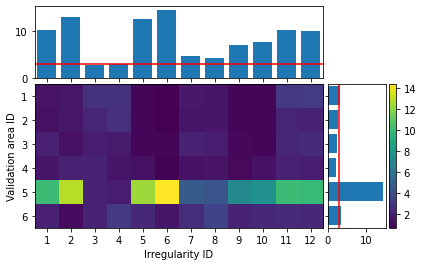

In [15]:
# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)
ax_histy = fig.add_axes(rect_histy)

im = ax.imshow(val_errors.abs().max(-1)[0].numpy())

ax_histx.bar(np.arange(12), val_errors.abs().max(-1)[0].max(0)[0].numpy())
ax_histx.axhline(2.94, color="r")
ax_histx.set_xlim([-.5, 11.5])
ax_histy.barh(np.arange(6), val_errors.abs().max(-1)[0].max(1)[0].numpy()[::-1])
ax_histy.axvline(2.94, color="r")
ax_histy.set_ylim([-.5, 5.5])

ax_histx.set_xticks([i for i in range(12)])
ax_histy.set_yticks([i for i in range(6)])
ax_histx.set_xticklabels([])
ax_histy.set_yticklabels([])

ax.set_xticks([i for i in range(0,12)])
ax.set_xticklabels([i for i in range(1,13)])
ax.set_yticks([i for i in range(0,6)])
ax.set_yticklabels([i for i in range(1,7)])

plt.colorbar(im)
ax.set_xlabel("Irregularity ID")
ax.set_ylabel("Validation area ID")

fig.savefig("plots/Errors max aggregates.pdf",format="pdf",bbox_inches="tight")
plt.show()

/tmp/ipykernel_3011/3847735503.py:27: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(im)


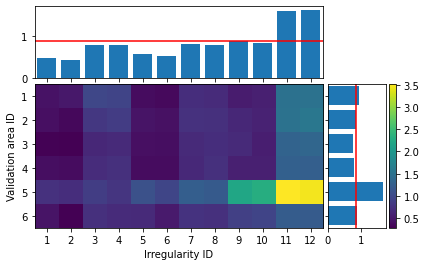

In [16]:
# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx)
ax_histy = fig.add_axes(rect_histy)

im = ax.imshow(val_errors.abs().quantile(0.95, -1).numpy())

ax_histx.bar(np.arange(12), [val_errors[:,i,:].abs().quantile(0.95).numpy() for i in range(12)])
ax_histx.axhline(0.87, color="r")
ax_histx.set_xlim([-.5, 11.5])
ax_histy.barh(np.arange(6), [val_errors[i,:,:].abs().quantile(0.95).numpy() for i in range(6)][::-1])
ax_histy.axvline(0.87, color="r")
ax_histy.set_ylim([-.5, 5.5])

ax_histx.set_xticks([i for i in range(12)])
ax_histy.set_yticks([i for i in range(6)])
ax_histx.set_xticklabels([])
ax_histy.set_yticklabels([])

ax.set_xticks([i for i in range(0,12)])
ax.set_xticklabels([i for i in range(1,13)])
ax.set_yticks([i for i in range(0,6)])
ax.set_yticklabels([i for i in range(1,7)])

plt.colorbar(im)
ax.set_xlabel("Irregularity ID")
ax.set_ylabel("Validation area ID")

fig.savefig("plots/Errors quantile aggregates.pdf",format="pdf",bbox_inches="tight")
plt.show()

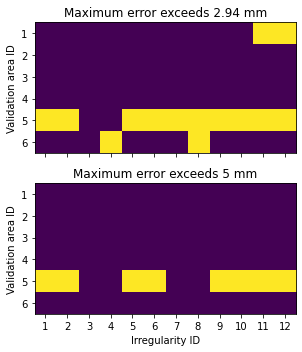

In [17]:
fig, axes = plt.subplots(2,1,figsize=(5, 5))

ax = axes[0]
ax.imshow(val_errors.abs().max(-1)[0].numpy() > 2.94)

ax.set_xticks([i for i in range(0,12)])
# ax.set_xticklabels([i for i in range(1,13)])
ax.set_xticklabels([])
ax.set_yticks([i for i in range(0,6)])
ax.set_yticklabels([i for i in range(1,7)])

ax.set_ylabel("Validation area ID")

ax.set_title("Maximum error exceeds 2.94 mm")

ax = axes[1]
ax.imshow(val_errors.abs().max(-1)[0].numpy() > 5)

ax.set_xticks([i for i in range(0,12)])
ax.set_xticklabels([i for i in range(1,13)])
ax.set_yticks([i for i in range(0,6)])
ax.set_yticklabels([i for i in range(1,7)])

ax.set_xlabel("Irregularity ID")
ax.set_ylabel("Validation area ID")

ax.set_title("Maximum error exceeds 5 mm")

fig.tight_layout()

fig.savefig("plots/Maximum exceeds level.pdf", format="pdf")

In [18]:
print(np.corrcoef(df_raw_train["Training errors"], df_raw_train["Training true values"]))
print(np.corrcoef(df_raw_val["Validation errors"], df_raw_val["Validation true values"]))
print(np.corrcoef(df_raw_val2["Validation errors"], df_raw_val2["Validation true values"]))

[[ 1.        -0.4263925]
 [-0.4263925  1.       ]]
[[ 1.         -0.40959676]
 [-0.40959676  1.        ]]
[[ 1.         -0.47036265]
 [-0.47036265  1.        ]]


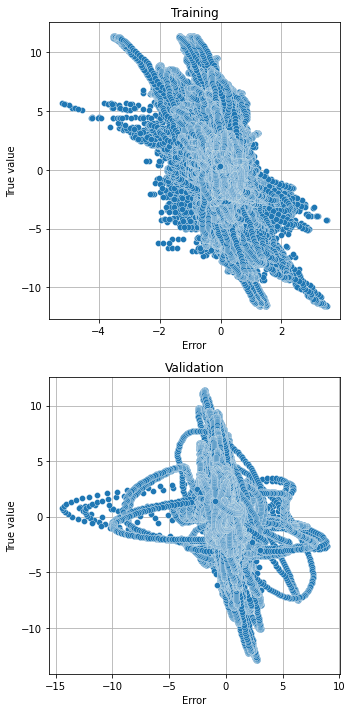

In [19]:
fig, axes = plt.subplots(2,1,figsize=(5,10))

ax = axes[0]
ax.scatter(df_raw_train["Training errors"], df_raw_train["Training true values"], edgecolors="w", linewidths=0.3)
ax.set_xlabel("Error")
ax.set_ylabel("True value")
ax.set_title("Training")
ax.grid()


ax = axes[1]
ax.scatter(df_raw_val["Validation errors"], df_raw_val["Validation true values"], edgecolors="w", linewidths=0.3)
ax.set_xlabel("Error")
ax.set_ylabel("True value")
ax.set_title("Validation")
ax.grid()

fig.tight_layout()

fig.savefig("plots/Error scatter plots.png", format="png", dpi=250)

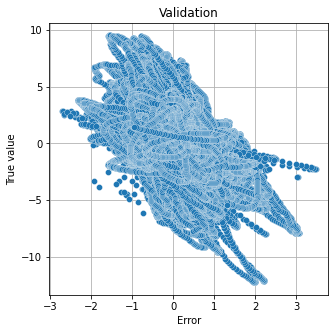

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(df_raw_val2["Validation errors"], df_raw_val2["Validation true values"], edgecolors="w", linewidths=0.3)
ax.set_xlabel("Error")
ax.set_ylabel("True value")
ax.set_title("Validation")
ax.grid()

fig.savefig("plots/Error scatter plots2.png", format="png", dpi=250, bbox_inches="tight")


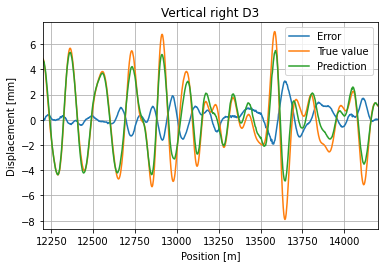

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,3.8))
ax.plot(positions[0]["val"], val_errors[0, 11], label="Error")
ax.plot(positions[0]["val"], val_true_values[0, 11], label="True value")
ax.plot(positions[0]["val"], val_true_values[0, 11] + val_errors[0, 11], label="Prediction")
# ax.set_xlim([positions[0]["val"][0],positions[0]["val"][2000]])
ax.set_xlim([12200, 14200])
ax.set_title(labels_y[11])
ax.set_xlabel("Position [m]")
ax.set_ylabel("Displacement [mm]")
ax.grid()
ax.legend()

fig.savefig("plots/CNN prediction example.pdf", format="pdf")

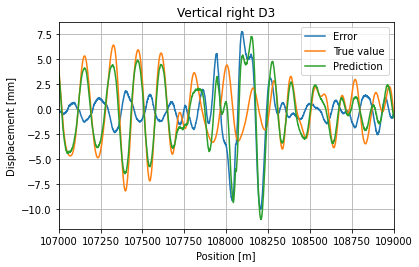

In [22]:
fig, ax = plt.subplots(1,1,figsize=(6,3.8))
ax.plot(positions[14]["val"], val_errors[4, 11], label="Error")
ax.plot(positions[14]["val"], val_true_values[4, 11], label="True value")
ax.plot(positions[14]["val"], val_true_values[4, 11] + val_errors[4, 11], label="Prediction")
ax.set_title(labels_y[11])
ax.set_xlabel("Position [m]")
ax.set_ylabel("Displacement [mm]")
# ax.set_xlim([positions[14]["val"][0], positions[14]["val"][-1]])
ax.set_xlim([107000, 109000])
ax.grid()
ax.legend()
fig.savefig("plots/CNN prediction example large errors.pdf", format="pdf")

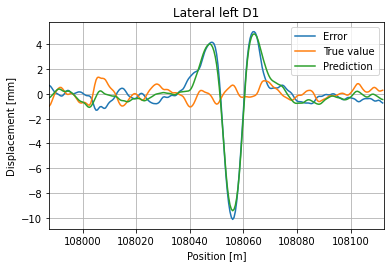

In [23]:
fig, ax = plt.subplots(1,1,figsize=(6,3.8))
ax.plot(positions[14]["val"][3750:4000], val_errors[4, 0, 3750:4000], label="Error")
ax.plot(positions[14]["val"][3750:4000], val_true_values[4, 0, 3750:4000], label="True value")
ax.plot(positions[14]["val"][3750:4000], val_true_values[4, 0, 3750:4000] + val_errors[4, 0, 3750:4000], label="Prediction")
ax.set_title(labels_y[0])
ax.set_xlabel("Position [m]")
ax.set_ylabel("Displacement [mm]")
ax.set_xlim([positions[14]["val"][3750], positions[14]["val"][4000]])
ax.grid()
ax.legend()

fig.savefig("plots/CNN prediction example large errors extra.pdf")

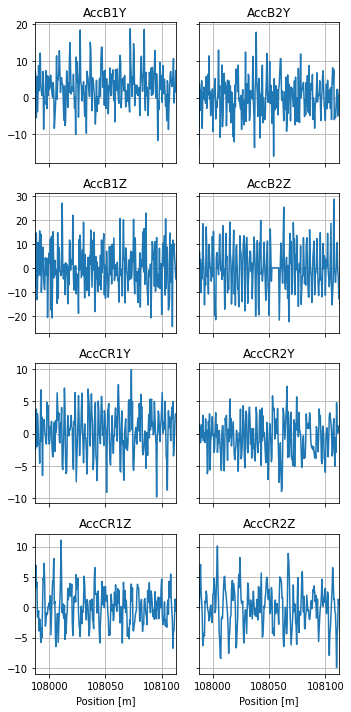

In [24]:
pos_start, pos_end = float(positions[14]["val"][3750]), float(positions[14]["val"][4000])
pos_plot = df_dynamics[pos_start:pos_end].index

fig, axes = plt.subplots(4, 2, figsize=(5,10), sharey="row", sharex=True)
axes = axes.T
for i, ax in enumerate(axes.flatten(), 1):
    ax.plot(pos_plot, df_dynamics.loc[pos_start:pos_end, i])
    ax.set_title(labels_X[i])
    if i < 4 == 1:
        ax.set_ylabel("Acceleration [m/s$^2$]")
    if i%4 == 0: 
        ax.set_xlabel('Position [m]')
    ax.set_xlim([pos_start, pos_end])
    ax.set_xticks([108000, 108050, 108100])
    ax.grid()

fig.tight_layout()

fig.savefig("plots/Input at large errors.pdf",format="pdf",bbox_inches="tight")

In [25]:
df_dynamics.loc[108052.5:108058.5, 6]

108052.5    0.0
108053.0    0.0
108053.5    0.0
108054.0    0.0
108054.5    0.0
108055.0    0.0
108055.5    0.0
108056.0    0.0
108056.5    0.0
108057.0    0.0
108057.5    0.0
108058.0    0.0
108058.5    0.0
Name: 6, dtype: float64

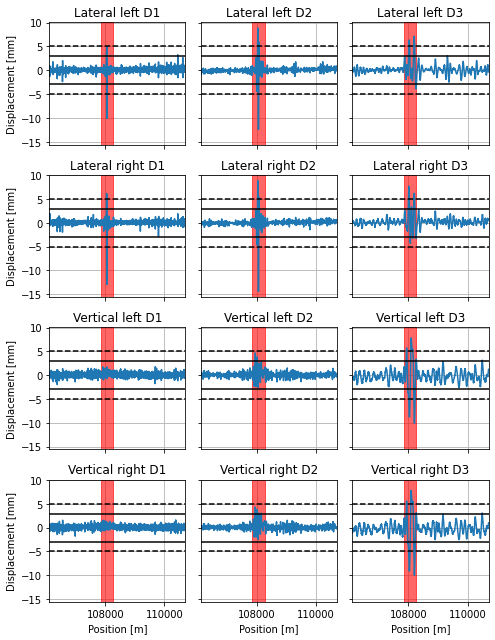

In [26]:
fig, axes = plt.subplots(4,3,figsize=(7,9), sharex=True, sharey=True)
axes = axes.T
for i, ax in enumerate(axes.flatten()):
    ax.plot(positions[14]["val"], val_errors[4, i], label="Error")
    ax.set_title(labels_y[i])
    if i%4 == 3: ax.set_xlabel("Position [m]")
    if i < 4: ax.set_ylabel("Displacement [mm]")
    

    ax.set_xlim([positions[14]["val"][0], positions[14]["val"][-1]])
    ax.axvspan(108052.5-202, 108058.5+202, alpha=0.6, color='red')

    ax.hlines([-5, 5], xmin=positions[14]["val"][0], xmax=positions[14]["val"][-1], color="k", linestyle="--")
    ax.hlines([-2.94, 2.94], xmin=positions[14]["val"][0], xmax=positions[14]["val"][-1], color="k", linestyle="-")

    ax.grid()

fig.tight_layout()

fig.savefig("plots/Assumption test for large errors.pdf")

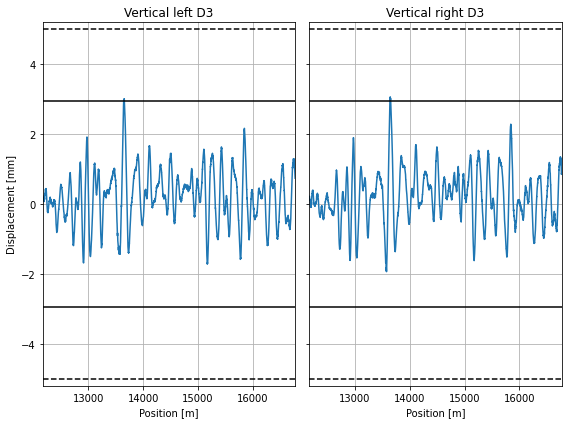

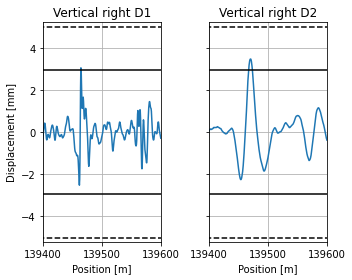

In [27]:
fig, axes = plt.subplots(1,2,figsize=(8,6), sharex=True, sharey="row")
for i, ax in zip([10, 11], axes.flatten()):
    ax.plot(positions[0]["val"], val_errors[0, i], label="Error")
    ax.set_ylim([-5.2, 5.2])
    ax.set_title(labels_y[i])
    ax.set_xlabel("Position [m]")
    if i == 10: ax.set_ylabel("Displacement [mm]")
    ax.set_xlim([positions[0]["val"][0], positions[0]["val"][-1]])
    # ax.axvspan(108052.5-202, 108058.5+202, alpha=0.6, color='red')

    ax.hlines([-5, 5], xmin=positions[0]["val"][0], xmax=positions[0]["val"][-1], color="k", linestyle="--")
    ax.hlines([-2.94, 2.94], xmin=positions[0]["val"][0], xmax=positions[0]["val"][-1], color="k", linestyle="-")
    ax.grid()

fig.tight_layout()

fig, axes = plt.subplots(1,2,figsize=(5,4), sharex=True, sharey="row")
for i, ax in zip([3, 7], axes.flatten()):
    ax.plot(positions[20]["val"], val_errors[5, i], label="Error")
    ax.set_ylim([-5.2, 5.2])
    ax.set_title(labels_y[i])
    ax.set_xlabel("Position [m]")
    if i == 3: ax.set_ylabel("Displacement [mm]")
    ax.set_xlim([positions[20]["val"][0], positions[20]["val"][-1]])
    ax.set_xlim([139400, 139600])
    # ax.axvspan(108052.5-202, 108058.5+202, alpha=0.6, color='red')

    ax.hlines([-5, 5], xmin=positions[20]["val"][0], xmax=positions[20]["val"][-1], color="k", linestyle="--")
    ax.hlines([-2.94, 2.94], xmin=positions[20]["val"][0], xmax=positions[20]["val"][-1], color="k", linestyle="-")

    ax.grid()

fig.tight_layout()

fig.savefig("plots/Error exceed in sixth area.pdf", format="pdf")

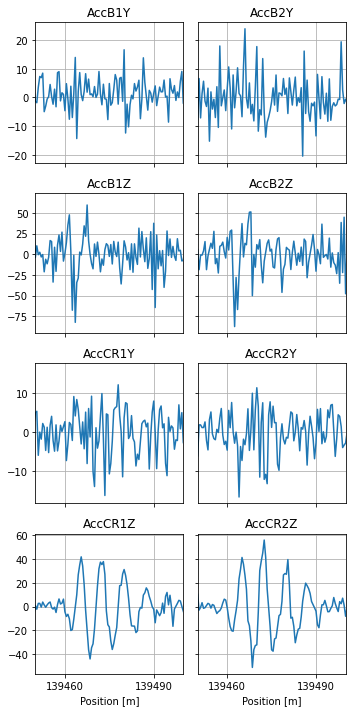

In [28]:
pos_start, pos_end = float(positions[20]["val"][6650]), float(positions[20]["val"][7000])
pos_plot = df_dynamics[pos_start:pos_end].index

fig, axes = plt.subplots(4, 2, figsize=(5,10), sharey="row", sharex=True)
axes = axes.T

for i, ax in enumerate(axes.flatten(), 1):
    ax.plot(pos_plot, df_dynamics.loc[pos_start:pos_end, i])
    ax.set_title(labels_X[i])
    if i < 4 == 1:
        ax.set_ylabel("Acceleration [m/s$^2$]")
    if i%4 == 0: 
        ax.set_xlabel('Position [m]')
    ax.set_xlim([139450, 139500])
    ax.set_xticks([139460, 139490])
    ax.set_xticklabels(["139460", "139490"])
    ax.grid()

fig.tight_layout()

fig.savefig("plots/Irregular bogies.pdf", format="pdf", bbox_inches="tight")

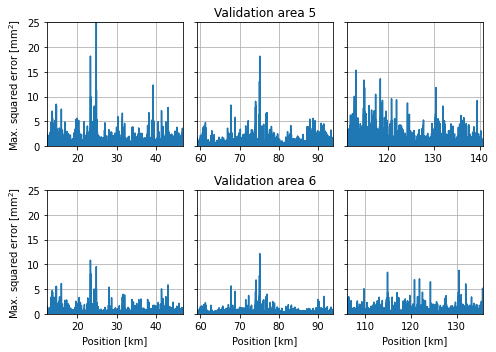

In [29]:
fig, axes = plt.subplots(2,3,figsize=(7,5),sharex=False, sharey=True)
feature = 0
for i,cv_index in enumerate([14, 20]):
    for area in range(3):
        ax = axes[i,area]
        ax.plot(positions[cv_index]["train"][area]/1000, (training_errors[cv_index][area][0]**2).max(0)[0])
        ax.set_xlim([positions[cv_index]["train"][area][0]/1000, positions[cv_index]["train"][area][-1]/1000])
        ax.set_ylim([0, 25])
        ax.grid()
        if area == 1:
            ax.set_title("Validation area " + str(i+5))
            # ax.set_title("cv_index " + str(cv_index))
        if i == 1:
            ax.set_xlabel("Position [km]")
        if area == 0:
            ax.set_ylabel("Max. squared error [mm$^2$]")

fig.tight_layout()

fig.savefig("plots/squared error area 5 and 6.pdf", bbox_inches="tight")

In [45]:
idxs = (training_errors[14][0][0]**2).max(0)[1]

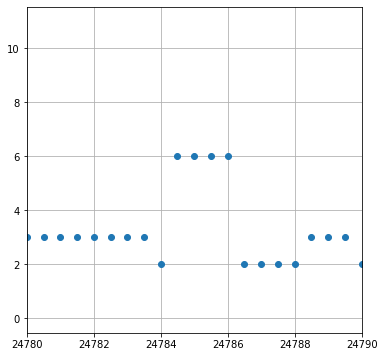

In [56]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(positions[14]["train"][0], idxs)
ax.set_xlim([24780, 24790])
ax.grid()


In [60]:
training_true_values[14][0].shape

torch.Size([12, 69192])

In [72]:
positions[cv_index]["train"][0].numpy().shape

(69192,)

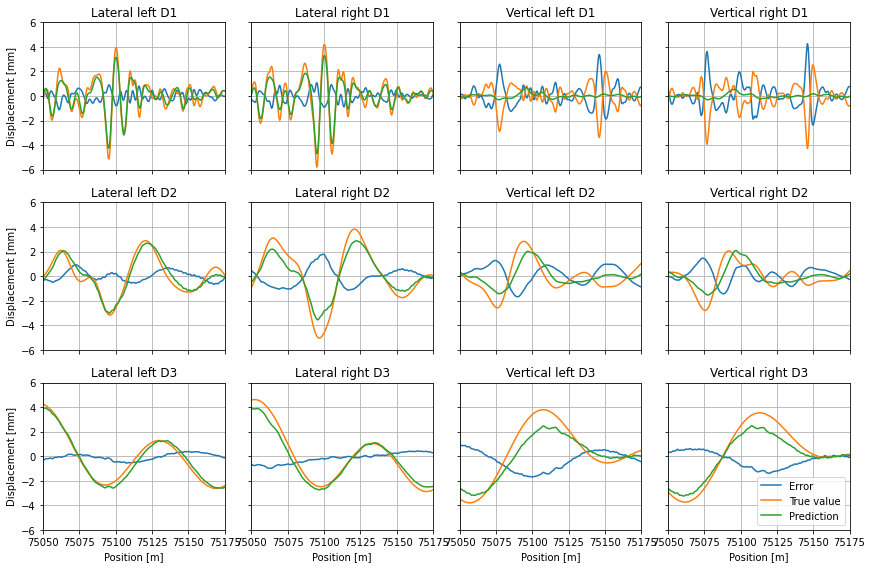

In [87]:
area = 1
cv_index = 14
df_err_local = pd.DataFrame(training_errors[cv_index][area][0].numpy().T, index=positions[cv_index]["train"][area].numpy())
df_true_local = pd.DataFrame(training_true_values[cv_index][area].numpy().T, index=positions[cv_index]["train"][area].numpy())
df_pred_local = pd.DataFrame((training_true_values[cv_index][area] + training_errors[cv_index][area][0]).numpy().T, 
    index=positions[cv_index]["train"][area].numpy())

fig, axes = plt.subplots(3,4,figsize=(12,8), sharex=True, sharey=True)
start_pos = 75050
end_pos = 75175
pos = df_err_local.loc[start_pos:end_pos].index
for feature, ax in enumerate(axes.flatten()):
    ax.plot(pos, df_err_local.loc[start_pos:end_pos, feature], label="Error")
    ax.plot(pos, df_true_local.loc[start_pos:end_pos, feature], label="True value")
    ax.plot(pos, df_pred_local.loc[start_pos:end_pos, feature], label="Prediction")
    ax.set_title(labels_y[feature])
    if feature >= 8:
        ax.set_xlabel("Position [m]")
    if feature%4==0:
        ax.set_ylabel("Displacement [mm]")
    # ax.set_xlim([positions[14]["val"][0], positions[14]["val"][-1]])
    ax.set_xlim([start_pos, end_pos])
    ax.set_ylim([-6, 6])
    ax.grid()
ax.legend()
fig.tight_layout()
fig.savefig("plots/CNN prediction example large training errors.pdf", format="pdf")

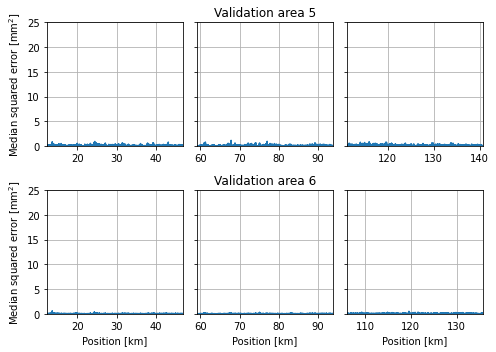

In [30]:
fig, axes = plt.subplots(2,3,figsize=(7,5),sharex=False, sharey=True)
feature = 0
for i,cv_index in enumerate([14, 20]):
    for area in range(3):
        ax = axes[i,area]
        ax.plot(positions[cv_index]["train"][area]/1000, (training_errors[cv_index][area][0]**2).median(0)[0])
        ax.set_xlim([positions[cv_index]["train"][area][0]/1000, positions[cv_index]["train"][area][-1]/1000])
        ax.set_ylim([0, 25])
        ax.grid()
        if area == 1:
            ax.set_title("Validation area " + str(i+5))
            # ax.set_title("cv_index " + str(cv_index))
        if i == 1:
            ax.set_xlabel("Position [km]")
        if area == 0:
            ax.set_ylabel("Median squared error [mm$^2$]")

fig.tight_layout()

fig.savefig("plots/squared error area 5 and 6 median.pdf", bbox_inches="tight")

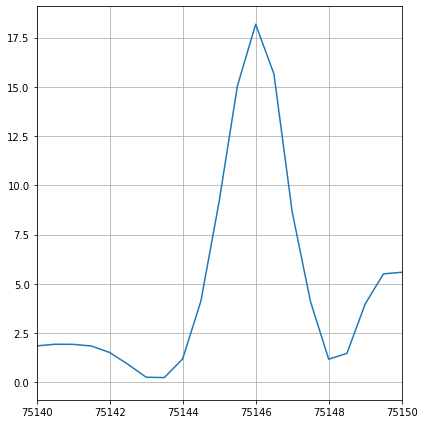

In [31]:
fig, ax = plt.subplots(1,1,figsize=(6,6),sharex=False, sharey=True)
feature = 0
i, cv_index = 4, 14
area = 1
ax.plot(positions[cv_index]["train"][area], (training_errors[cv_index][area][0]**2).max(0)[0])
ax.set_xlim([75140, 75150])
ax.grid()
        
fig.tight_layout()

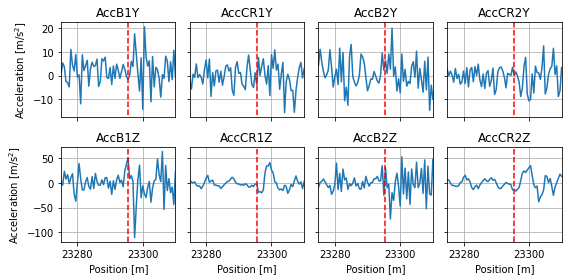

In [32]:
pos_start, pos_end = 23275, 23310
pos_plot = df_dynamics[pos_start:pos_end].index

fig, axes = plt.subplots(2, 4, figsize=(8,4), sharey="row", sharex=True)
axes = axes.T

for i, ax in enumerate(axes.flatten(), 1):
    ax.plot(pos_plot, df_dynamics.loc[pos_start:pos_end, i])
    ax.set_title(labels_X[i])
    if i < 3:
        ax.set_ylabel("Acceleration [m/s$^2$]")
    if i%2 == 0: 
        ax.set_xlabel('Position [m]')
    ax.set_xlim([pos_start, pos_end])
    #ax.set_xticks([139460, 139490])
    #ax.set_xticklabels(["139460", "139490"])
    ax.grid()
    if i%2 == 1:
        ax.vlines(23295.5, ymin=-20, ymax=25, color="r", ls="--")
        ax.set_ylim([-17.4185, 22.4125])
    else:
        ax.vlines(23295.5, ymin=-120, ymax=75, color="r", ls="--")
        ax.set_ylim([-119.86045, 72.93545])

fig.tight_layout()

fig.savefig("plots/Dynamics at training error 23km.pdf", format="pdf", bbox_inches="tight")

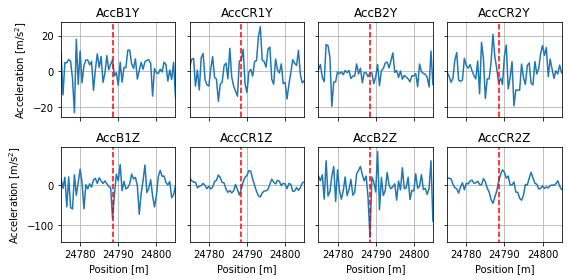

In [33]:
pos_start, pos_end = 24775, 24805
pos_plot = df_dynamics[pos_start:pos_end].index

fig, axes = plt.subplots(2, 4, figsize=(8,4), sharey="row", sharex=True)
axes = axes.T

for i, ax in enumerate(axes.flatten(), 1):
    ax.plot(pos_plot, df_dynamics.loc[pos_start:pos_end, i])
    ax.set_title(labels_X[i])
    if i < 3:
        ax.set_ylabel("Acceleration [m/s$^2$]")
    if i%2 == 0: 
        ax.set_xlabel('Position [m]')
    ax.set_xlim([pos_start, pos_end])
    #ax.set_xticks([139460, 139490])
    #ax.set_xticklabels(["139460", "139490"])
    ax.grid()
    if i%2 == 1:
        ax.vlines(24788.5, ymin=-30, ymax=30, color="r", ls="--")
        ax.set_ylim([-25.3683, 27.372300000000003])
    else:
        ax.vlines(24788.5, ymin=-150, ymax=100, color="r", ls="--")
        ax.set_ylim([-142.247, 95.617])

fig.tight_layout()

fig.savefig("plots/Dynamics at training error 25km.pdf", format="pdf", bbox_inches="tight")

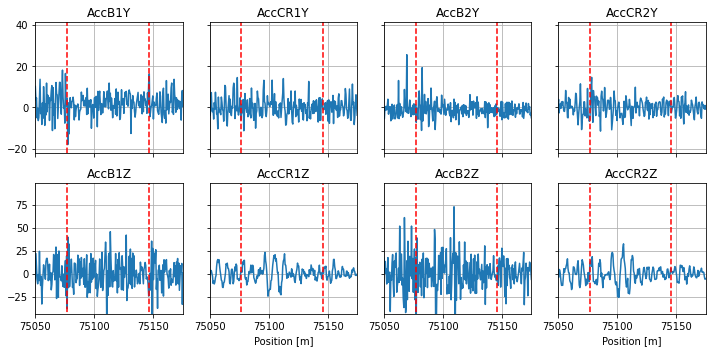

In [34]:
pos_start, pos_end = 75050, 75175
pos_plot = df_dynamics[pos_start:pos_end].index

fig, axes = plt.subplots(2, 4, figsize=(10,5), sharey="row", sharex=True)
axes = axes.T

for i, ax in enumerate(axes.flatten(), 1):
    ax.plot(pos_plot, df_dynamics.loc[pos_start:pos_end, i])
    ax.set_title(labels_X[i])
    if i < 4 == 1:
        ax.set_ylabel("Acceleration [m/s$^2$]")
    if i%4 == 0: 
        ax.set_xlabel('Position [m]')
    ax.set_xlim([pos_start, pos_end])
    ax.grid()
    if i%2 == 1:
        ax.vlines((75077, 75146), ymin=-30, ymax=50, color="r", ls="--")
        ax.set_ylim([-22.07615, 41.067150000000005])
    else:
        ax.vlines((75077, 75146), ymin=-50, ymax=100, color="r", ls="--")
        ax.set_ylim([-43.5556, 98.0936])

fig.tight_layout()

fig.savefig("plots/Dynamics at training error 75km.pdf", format="pdf", bbox_inches="tight")

In [35]:
axes[1,1].get_ylim()

(-43.5556, 98.0936)

In [36]:
print((train_errors_collected**2).mean())
print((train_errors_collected**2).median())
print((train_errors_collected**2).quantile(0.95))
print((train_errors_collected**2).max())
print((train_errors_collected**2).max()/(train_errors_collected**2).median())


tensor(0.0656)
tensor(0.0178)
tensor(0.2676)
tensor(26.9088)
tensor(1508.0951)


In [37]:
training_true_values[cv_index][area].shape

torch.Size([12, 69192])

In [38]:
(training_errors[cv_index][area]).shape

torch.Size([1, 12, 69192])

In [39]:
Gamma = np.logspace(np.log10(0.9), np.log10(1.3), 50)
MAEs = np.zeros_like(Gamma)
for i,gamma in enumerate(Gamma):
    errors = np.concatenate([((gamma-1)*training_true_values[cv_index][area]+gamma*training_errors[cv_index][area][0]).flatten() 
    for cv_index in training_errors for area in range(3)])
    MAEs[i] = np.mean(np.abs(errors))


Best factor: 1.053624177483841


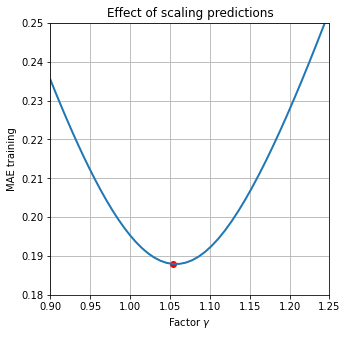

In [40]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(Gamma, MAEs, linewidth=2)
ax.scatter(Gamma[np.argmin(MAEs)], MAEs[np.argmin(MAEs)], color="r", zorder=1)
# ax.set_xscale("log")
ax.set_xlim((Gamma[[0]],1.25))
ax.set_ylim((0.18, 0.25))
ax.set_ylabel("MAE training")
ax.set_xlabel("Factor $\gamma$")
ax.set_title("Effect of scaling predictions")
ax.grid()
ax.set_axisbelow(True)
ax.set_zorder(1)

fig.savefig("plots/Scale preditions.pdf", format="pdf")

print("Best factor:", Gamma[np.argmin(MAEs)])